# Project Introduction


In recent years, real-time win probability models have become a valuable tool for interpreting the flow and outcome of sporting events. These models provide fans, analysts, and coaches with dynamic insights into a team’s likelihood of victory as the game progresses, based on contextual in-game features. In this project, we developed a deep learning model to estimate the win probability of the Houston Rockets at each point during an NBA game, using only in-game play-by-play data.

We retrieved our data using the nba_api Python library, an official interface to NBA.com’s stats endpoints. Specifically, we utilized the PlayByPlayV3 endpoint to download event-level data for every game played by the Houston Rockets during the 2023–2024 NBA regular season. Each game contains a chronological list of possessions and actions — such as made shots, rebounds, fouls, and turnovers — along with game clock, team IDs, and scores.

Our problem is framed as a binary sequence classification task: at each point in the game, the model outputs a win probability (between 0 and 1), which estimates whether the Rockets will ultimately win. This problem is both sequential and time-dependent, making it well-suited for recurrent neural networks (RNNs), which are capable of modeling temporal dependencies across sequential data.

We focused on building a win probability model from the perspective of a single team — the Houston Rockets — using a streamlined, interpretable set of features engineered directly from the play-by-play logs. Our goal was to evaluate whether a deep learning model could learn meaningful win dynamics and generate realistic probability curves that reflect in-game momentum swings and score changes.

# Load Data

In [87]:
# Load your rockets_summary.csv first
import pandas as pd

summary = pd.read_csv("/content/drive/MyDrive/Rockets project/rockets_summary.csv")
summary = summary.sort_values('GAME_DATE')  # Ensure chronological order

# 70% train, 30% test
train_game_ids = summary['GAME_ID'].iloc[:57].tolist()   # first 57 games
test_game_ids  = summary['GAME_ID'].iloc[57:].tolist()   # last 25 games


## Load and combine all play-by-play CSVs

In [88]:
import pandas as pd
import os
import glob

# Path to play-by-play data folder in your Drive
pbp_path = "/content/drive/MyDrive/Rockets project/pbp_data"

# Load all CSV files
pbp_files = glob.glob(os.path.join(pbp_path, "*.csv"))
all_games_df = pd.concat([pd.read_csv(f) for f in pbp_files], ignore_index=True)

print(f"Total events loaded: {len(all_games_df)}")
print(f"Unique games: {all_games_df['GAME_ID'].nunique()}")


Total events loaded: 41241
Unique games: 82


## Load Game Summary

In [89]:
summary_path = "/content/drive/MyDrive/Rockets project/rockets_summary.csv"
rockets_summary = pd.read_csv(summary_path)
rockets_summary['GAME_DATE'] = pd.to_datetime(rockets_summary['GAME_DATE'])

# Sort for time-based splitting
rockets_summary = rockets_summary.sort_values('GAME_DATE').reset_index(drop=True)


## Train/Test Split by Game ID

In [90]:
# 70/30 chronological split
train_game_ids = rockets_summary['GAME_ID'].iloc[:57].tolist()
test_game_ids = rockets_summary['GAME_ID'].iloc[57:].tolist()

# Tag rows in play-by-play data
all_games_df['dataset_split'] = all_games_df['GAME_ID'].apply(
    lambda gid: 'train' if gid in train_game_ids else 'test'
)

# Merge in win/loss labels
all_games_df = all_games_df.merge(
    rockets_summary[['GAME_ID', 'rockets_win']],
    on='GAME_ID',
    how='left'
)

print(all_games_df[['GAME_ID', 'dataset_split', 'rockets_win']].head())


    GAME_ID dataset_split  rockets_win
0  22301199          test            1
1  22301199          test            1
2  22301199          test            1
3  22301199          test            1
4  22301199          test            1


# EDA

## Distribution of Event Types

This bar chart displays the frequency of the top 15 actionType events recorded across all Houston Rockets games in the 2023–2024 NBA season. These actionType values are categorical descriptors assigned by the NBA to each play in the play-by-play log.

We observe that the most common event types include:

Rebound (most frequent): indicating the high volume of missed shot recoveries in an average game

Missed Shot and Made Shot: together accounting for most field goal attempts

Free Throw and Substitution: both frequent and essential parts of game flow

Less frequent but still notable events include Foul, Turnover, and Timeout. Rare events such as Jump Ball, Violation, and Ejection appear much less often.

Understanding this distribution helped guide our feature engineering. Instead of using overlapping indicators like isFieldGoal, shotResult, or shotDistance, we chose to rely solely on the encoded actionType feature to capture play context. This reduced feature redundancy and emphasized the game's evolving structure while maintaining interpretability.

<Axes: title={'center': 'Top 15 Action Types'}, ylabel='actionType'>

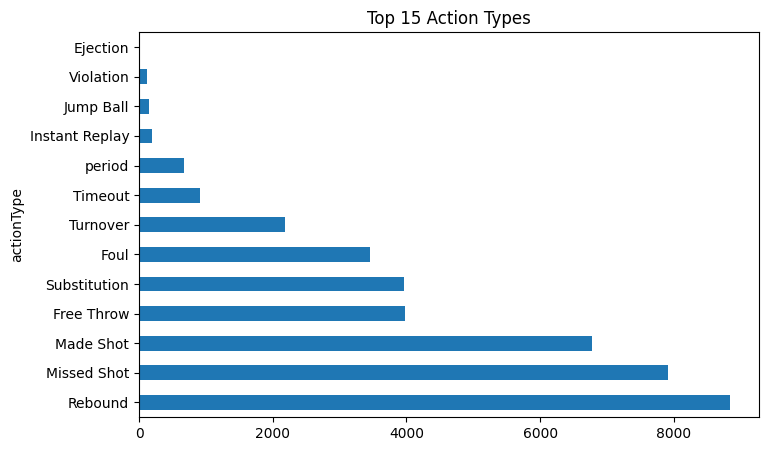

In [91]:
all_games_df['actionType'].value_counts().head(15).plot(kind='barh', figsize=(8, 5), title='Top 15 Action Types')


## Distribution of Score Differential

This histogram shows the distribution of the score differential at each event across all Houston Rockets games in the 2023–2024 NBA season. The score differential was computed as scoreHome - scoreAway, representing the home team’s lead at the time of each play.

The distribution is approximately bell-shaped and centered near zero, which aligns with expectations in competitive games where the score margin fluctuates frequently. The majority of events occur when the score differential is between −10 and +15 points, indicating most plays happen during relatively close games.

However, this raw score differential is home-team-centric and does not account for whether the Rockets were playing at home or away. This limitation could confuse a model attempting to learn win dynamics from the Rockets’ perspective, since a positive score differential does not always mean the Rockets are winning.

Recognizing this, we later replaced score_diff with a Rockets-specific score differential (rockets_score_diff) during feature engineering. This version correctly adjusts the sign of the score based on whether the Rockets were the home or visiting team, ensuring that positive values always reflect a Rockets lead.

<Axes: >

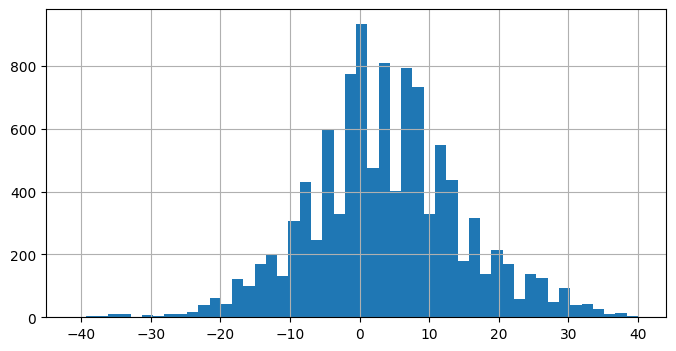

In [92]:
all_games_df['score_diff'] = all_games_df['scoreHome'] - all_games_df['scoreAway']

all_games_df['score_diff'].hist(bins=50, figsize=(8, 4))



## Win/Loss Balance - 50/50 split - The Houston Rockets went 41/41 in the 2023-2024 NBA Season

This bar chart displays the final win/loss record of the Houston Rockets during the 2023–2024 NBA regular season. As indicated, the team finished the season with a perfectly balanced record of 41 wins and 41 losses.

This even 50/50 split provides a naturally balanced dataset for binary classification tasks like win prediction. Having roughly equal representation of wins (rockets_win = 1) and losses (rockets_win = 0) ensures that the model does not become biased toward overpredicting one outcome over the other.

This win/loss record was used to label each game with a binary outcome, which was then expanded to label every timestep (event) within the game. These per-timestep labels were critical in training the model to predict the probability of a Rockets win as the game progressed.

<Axes: title={'center': 'Win/Loss Count'}, xlabel='rockets_win'>

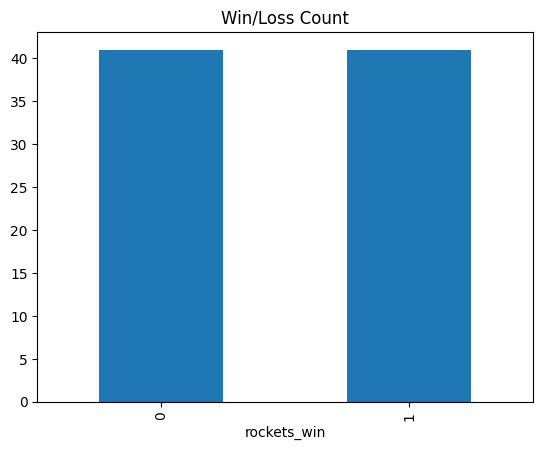

In [93]:
rockets_summary['rockets_win'].value_counts().plot(kind='bar', title='Win/Loss Count')


## Possession Count per Game

This histogram shows the distribution of the total number of play-by-play events (or possessions/actions) recorded per game for the Houston Rockets during the 2023–2024 NBA season. Each game contains a sequential list of all game events, including shot attempts, rebounds, fouls, substitutions, timeouts, and more.

Most games had between 470 and 530 events, with a peak around 480–490, which aligns with expectations for a regulation-length NBA game. A small number of games reached over 580 events, likely due to overtime periods or unusually eventful games.

This distribution was important when deciding how to preprocess input sequences for the model. Since RNNs require uniform input length, we chose to pad or truncate each game’s event sequence to 512 steps, ensuring all inputs had consistent shape while preserving most of the in-game context. Games with fewer than 512 events were zero-padded at the end, while longer games were truncated to their first 512 events.

This decision balanced sequence coverage with computational efficiency, allowing the model to learn from a standardized input format while still capturing nearly all regulation-length games in full.

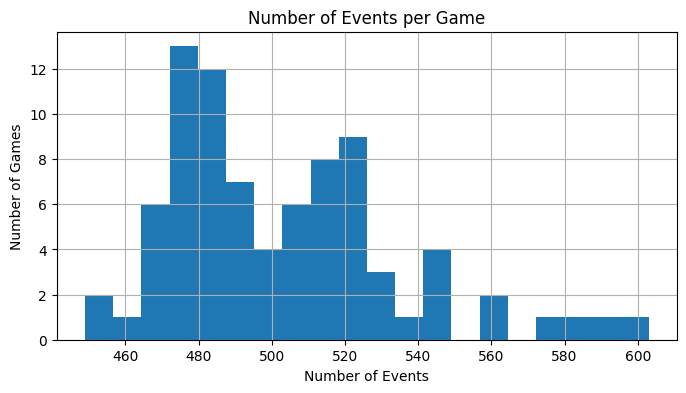

In [94]:
import matplotlib.pyplot as plt

possessions_per_game = all_games_df.groupby('GAME_ID').size()

plt.figure(figsize=(8, 4))
plt.hist(possessions_per_game, bins=20)
plt.xlabel("Number of Events")
plt.ylabel("Number of Games")
plt.title("Number of Events per Game")
plt.grid(True)
plt.show()



##Cleaning Data

During initial inspection of the play-by-play data, we observed that the scoreHome and scoreAway columns occasionally contained missing (NaN) values. These missing values typically occurred at the beginning of the game or immediately after quarter breaks, before any points had been scored.

To address this, we applied a two-step cleaning strategy:

Forward-fill missing scores:
We used the .fillna(method='ffill') operation to propagate the most recent non-null score forward. This ensures that every event in the game is associated with the correct running total of the current score, even if no scoring event occurred at that moment. Forward-filling is especially important for modeling, since score context is essential for calculating the current game state (e.g., score differential).

Fill any remaining nulls with 0:
After forward-filling, any scores that remained NaN (typically only at the start of the game) were set to 0. This makes sense semantically, as the game always begins with both teams at zero points.

This preprocessing step ensured that score-based features (like the Rockets-specific score differential) could be computed cleanly and consistently for every play in the dataset, without introducing artificial gaps in the scoring timeline.

### Forward Fill both score columns

In [95]:
all_games_df['scoreHome'] = all_games_df['scoreHome'].fillna(method='ffill')
all_games_df['scoreAway'] = all_games_df['scoreAway'].fillna(method='ffill')
# all_games_df['scoreHome']


<ipython-input-95-d7833d0c1d2d>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_games_df['scoreHome'] = all_games_df['scoreHome'].fillna(method='ffill')
<ipython-input-95-d7833d0c1d2d>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_games_df['scoreAway'] = all_games_df['scoreAway'].fillna(method='ffill')


###fill leading NaNs (e.g., before first score is posted)

In [96]:
all_games_df['scoreHome'] = all_games_df['scoreHome'].fillna(0)
all_games_df['scoreAway'] = all_games_df['scoreAway'].fillna(0)


In [97]:
all_games_df.head()

,gameId,actionNumber,clock,period,teamId,teamTricode,personId,playerName,playerNameI,xLegacy,...,description,actionType,subType,videoAvailable,shotValue,actionId,GAME_ID,dataset_split,rockets_win,score_diff
0,22301199,2,PT12M00.00S,1,0,NaN,0,NaN,NaN,0,...,Start of 1st Period (3:41 PM EST),period,start,0,0,1,22301199,test,1,0.0
1,22301199,4,PT12M00.00S,1,1610612746,LAC,203486,Plumlee,M. Plumlee,0,...,Jump Ball Plumlee vs. Landale: Tip to Moon,Jump Ball,NaN,1,0,2,22301199,test,1,NaN
2,22301199,7,PT11M52.00S,1,1610612746,LAC,1629611,Mann,T. Mann,-189,...,MISS Mann 26' 3PT Jump Shot,Missed Shot,Jump Shot,1,3,3,22301199,test,1,NaN
3,22301199,8,PT11M50.00S,1,1610612745,HOU,1631095,Smith Jr.,J. Smith Jr.,0,...,Smith Jr. REBOUND (Off:0 Def:1),Rebound,Unknown,1,0,4,22301199,test,1,NaN
4,22301199,9,PT11M34.00S,1,1610612745,HOU,1630224,Green,J. Green,-158,...,MISS Ja. Green 27' 3PT Jump Shot,Missed Shot,Jump Shot,1,3,5,22301199,test,1,NaN


In [98]:
rockets_summary.head()

,GAME_ID,GAME_DATE,home_team,away_team,hou_score,opp_score,rockets_win
0,22300066,2023-10-25,ORL,HOU,86,116.0,0
1,22300083,2023-10-27,SAS,HOU,122,126.0,0
2,22300096,2023-10-29,HOU,GSW,95,106.0,0
3,22300122,2023-11-01,HOU,CHA,128,119.0,1
4,22300137,2023-11-04,HOU,SAC,107,89.0,1


# Feature Engineering

To prepare the data for modeling, we engineered a focused and interpretable set of features based on play-by-play context. These features were designed to reflect the game state from the Houston Rockets’ perspective and to provide the model with meaningful temporal and contextual signals at each event in the game.

The key steps in feature engineering included:

1. Rockets-Specific Score Differential
We merged home_team information from the rockets_summary table into the play-by-play dataset to determine whether the Rockets were playing at home or away. We then computed a rockets-centric score differential for every event:

- If the Rockets were the home team: scoreHome − scoreAway

- If the Rockets were the away team: scoreAway − scoreHome
This transformation ensured that a positive value always indicates the Rockets are leading, regardless of their home/away status.

2. Ball Possession Indicator
Using the location field ('h' for home, 'v' for visitor), we created a binary rockets_possession feature that identifies whether the Rockets had possession of the ball at each event. This was essential for modeling momentum and understanding how possession impacted win probability.

3. Encoded Action Types
Each play is associated with a textual actionType (e.g., "Made Shot", "Foul", "Rebound"). We used LabelEncoder to convert these categorical strings into integers (actionType_encoded) so they could be fed into an embedding layer in the RNN model.

4. Time Remaining (Normalized)
The clock column provided time in ISO 8601 format (e.g., PT9M32.50S for 9 minutes and 32.5 seconds). We parsed this format using regular expressions and calculated the total seconds remaining in the game, accounting for quarter and overtime periods. Finally, we normalized the result by dividing by 2880 (the total number of seconds in a regulation game), yielding a time_remaining value between 0 and 1.

## Merge game metadata onto play by play to understand if Rockets are Home / Visitor Team

In [99]:
all_games_df = all_games_df.merge(
    rockets_summary[['GAME_ID', 'home_team']],
    on='GAME_ID',
    how='left'
)


## Calculate rockets_score_diff feature

In [100]:
# Fill forward scores
all_games_df['scoreHome'] = all_games_df['scoreHome'].fillna(method='ffill')
all_games_df['scoreAway'] = all_games_df['scoreAway'].fillna(method='ffill')

# Rockets-centric differential
def get_rockets_score_diff(row):
    if row['home_team'] == 'HOU':
        return row['scoreHome'] - row['scoreAway']
    else:
        return row['scoreAway'] - row['scoreHome']

all_games_df['rockets_score_diff'] = all_games_df.apply(get_rockets_score_diff, axis=1)


<ipython-input-100-81e7c94c4ecf>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_games_df['scoreHome'] = all_games_df['scoreHome'].fillna(method='ffill')
<ipython-input-100-81e7c94c4ecf>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_games_df['scoreAway'] = all_games_df['scoreAway'].fillna(method='ffill')


## Create rockets_possesion feature which indicates if Rockets have the ball possession

In [101]:
def get_rockets_possession(row):
    if pd.isna(row['location']):
        return 0  # No one has possession (e.g., between quarters)
    if row['home_team'] == 'HOU':
        return 1 if row['location'] == 'h' else 0
    else:
        return 1 if row['location'] == 'v' else 0

all_games_df['rockets_possession'] = all_games_df.apply(get_rockets_possession, axis=1)


## Label Encode Action Type

In [102]:
from sklearn.preprocessing import LabelEncoder
le_action = LabelEncoder()
all_games_df['actionType'] = all_games_df['actionType'].fillna("Unknown")
all_games_df['actionType_encoded'] = le_action.fit_transform(all_games_df['actionType'])


## Create Time-Remaining Feature

create function to parse the time remaining from 'clock' column

In [103]:
import re

def parse_clock_iso8601(clock_str):
    """Convert ISO 8601 period clock to total seconds."""
    try:
        match = re.match(r'PT(\d+)M([\d\.]+)S', clock_str)
        if match:
            minutes = int(match.group(1))
            seconds = float(match.group(2))
            return minutes * 60 + seconds
    except:
        pass
    return 0.0



In [104]:
def get_total_seconds_remaining(clock_str, period):
    seconds_left_in_period = parse_clock_iso8601(clock_str)

    if pd.isnull(period) or period < 1:
        return 0.0

    # Regular periods = 12 minutes
    if period <= 4:
        periods_remaining = 4 - period
        total_seconds_remaining = periods_remaining * 12 * 60 + seconds_left_in_period
    else:
        # Overtime periods = 5 minutes
        overtime_remaining = period - 4 - 1
        total_seconds_remaining = overtime_remaining * 5 * 60 + seconds_left_in_period

    return total_seconds_remaining


Call on play-by-play data

In [105]:
all_games_df['time_remaining'] = all_games_df.apply(
    lambda row: get_total_seconds_remaining(row['clock'], row['period']),
    axis=1
)


In [106]:
all_games_df.head(10)

,gameId,actionNumber,clock,period,teamId,teamTricode,personId,playerName,playerNameI,xLegacy,...,actionId,GAME_ID,dataset_split,rockets_win,score_diff,home_team,rockets_score_diff,rockets_possession,actionType_encoded,time_remaining
0,22301199,2,PT12M00.00S,1,0,NaN,0,NaN,NaN,0,...,1,22301199,test,1,0.0,LAC,0.0,0,13,2880.0
1,22301199,4,PT12M00.00S,1,1610612746,LAC,203486,Plumlee,M. Plumlee,0,...,2,22301199,test,1,NaN,LAC,0.0,0,4,2880.0
2,22301199,7,PT11M52.00S,1,1610612746,LAC,1629611,Mann,T. Mann,-189,...,3,22301199,test,1,NaN,LAC,0.0,0,6,2872.0
3,22301199,8,PT11M50.00S,1,1610612745,HOU,1631095,Smith Jr.,J. Smith Jr.,0,...,4,22301199,test,1,NaN,LAC,0.0,1,7,2870.0
4,22301199,9,PT11M34.00S,1,1610612745,HOU,1630224,Green,J. Green,-158,...,5,22301199,test,1,NaN,LAC,0.0,1,6,2854.0
5,22301199,10,PT11M30.00S,1,1610612746,LAC,1629611,Mann,T. Mann,0,...,6,22301199,test,1,NaN,LAC,0.0,0,7,2850.0
6,22301199,11,PT11M22.00S,1,1610612746,LAC,1629875,Moon,X. Moon,-49,...,7,22301199,test,1,NaN,LAC,0.0,0,6,2842.0
7,22301199,12,PT11M20.00S,1,0,NaN,1610612745,NaN,NaN,0,...,8,22301199,test,1,NaN,LAC,0.0,1,7,2840.0
8,22301199,14,PT11M08.00S,1,1610612745,HOU,1641708,Thompson,A. Thompson,17,...,9,22301199,test,1,-2.0,LAC,2.0,1,5,2828.0
9,22301199,16,PT10M42.00S,1,1610612746,LAC,1629599,Coffey,A. Coffey,161,...,10,22301199,test,1,NaN,LAC,2.0,0,6,2802.0


##Normalize Time Remaining

In [107]:
all_games_df['time_remaining'] = all_games_df['time_remaining'] / 2880


In [108]:
FEATURE_COLS = [
    'time_remaining',         # normalized [0, 1]
    'rockets_score_diff',     # centered score diff (can be + or -)
    'rockets_possession',     # 1 if Rockets have the ball
    'actionType_encoded'      # categorical event type
]



# Model Building - Preparing Sequences for RNN Input

## Generate X_data and Y_data

To train a sequence model like an RNN, we first needed to reshape the event-level play-by-play data into uniform, fixed-length sequences representing each game. Recurrent Neural Networks require inputs of consistent shape, so we padded or truncated each game to a standard length of 512 events.

1. Padding or Truncating Event Sequences
Each game consists of a variable number of play-by-play events. To standardize the shape of our input data, we defined a helper function:

2. Creating Model Input Arrays

3. Expanding Labels to Per-Timestep Format

In [109]:
import numpy as np

def pad_or_truncate_sequence(seq_df, seq_len=512):
    seq = seq_df[FEATURE_COLS].values
    if len(seq) >= seq_len:
        return seq[:seq_len]
    else:
        padding = np.zeros((seq_len - len(seq), len(FEATURE_COLS)))
        return np.vstack([seq, padding])

X_data = []
y_data = []

for game_id, group in all_games_df.groupby('GAME_ID'):
    features = pad_or_truncate_sequence(group)
    label = group['rockets_win'].iloc[0]
    X_data.append(features)
    y_data.append(label)

X_data = np.array(X_data)
y_data = np.array(y_data)

# Expand game-level label to match each timestep
Y_data = np.array([[label] * 512 for label in y_data])
Y_data = np.expand_dims(Y_data, axis=2)  # shape: (n_games, 512, 1)


##Define Train/Test Split

To evaluate model generalization, we performed a 70/30 split of the data:

train_idx: indexes of games used for training (~57 games)

test_idx: indexes of games held out for testing (~25 games)

We also recorded the list of test GAME_IDs so we could later match predictions to the correct metadata (date, opponent, outcome) when visualizing results.

In [124]:
from sklearn.model_selection import train_test_split

# Split indices
game_indices = np.arange(len(X_data))  # 0 to 81
train_idx, test_idx = train_test_split(game_indices, test_size=0.3, random_state=42, shuffle=True)


In [125]:
test_game_ids = [list(all_games_df.groupby('GAME_ID').groups.keys())[i] for i in test_idx]


##Split Train/Test and Convert to Tensors

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim

X_train = X_data[train_idx]
X_test = X_data[test_idx]
Y_train = Y_data[train_idx]
Y_test = Y_data[test_idx]

# Split into numeric + categorical
x_numeric_train = torch.tensor(X_train[:, :, :3], dtype=torch.float32)  # time_remaining, score_diff, possession
x_action_train  = torch.tensor(X_train[:, :, 3].astype(int), dtype=torch.long)
y_train_tensor  = torch.tensor(Y_train, dtype=torch.float32)

x_numeric_test = torch.tensor(X_test[:, :, :3], dtype=torch.float32)
x_action_test  = torch.tensor(X_test[:, :, 3].astype(int), dtype=torch.long)
y_test_tensor  = torch.tensor(Y_test, dtype=torch.float32)


## Model Architecture: Rockets Win Probability RNN


To model the evolving probability of a Rockets win throughout each game, we implemented a custom Recurrent Neural Network (RNN) using PyTorch. The RNN was designed to process sequential, event-by-event input and output a predicted win probability at every timestep (event index).

We defined a custom neural network class RocketsWinProbRNN(nn.Module) with the following architecture:

Embedding Layer:
The categorical actionType_encoded feature is passed through an nn.Embedding layer to learn a dense vector representation of each action type. This transforms a single integer input per timestep into an 8-dimensional vector.

Input Concatenation:
The embedded action vectors are concatenated with the other 3 numeric features (time_remaining, rockets_score_diff, rockets_possession) to form the complete input at each timestep. The resulting input shape per event is input_size + embed_dim = 3 + 8 = 11.

LSTM Layers:
A two-layer LSTM (nn.LSTM) processes the concatenated input sequence. This recurrent component allows the model to track evolving game context by learning temporal dependencies over time. The hidden state size is 128 units.

Fully Connected Output Layer:
The output of the final LSTM layer at each timestep is passed through a linear layer (nn.Linear) to reduce the dimensionality to a single logit per event. This logit is later passed through a sigmoid function to obtain a win probability between 0 and 1.

In [127]:
class RocketsWinProbRNN(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2, num_action_types=30, embed_dim=8, dropout=0.2):
        super().__init__()
        self.action_embed = nn.Embedding(num_action_types, embed_dim)
        self.rnn_input_size = input_size + embed_dim

        self.lstm = nn.LSTM(
            input_size=self.rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x_numeric, x_action):
        x_embed = self.action_embed(x_action)
        x = torch.cat([x_numeric, x_embed], dim=2)
        out, _ = self.lstm(x)
        logits = self.fc(out)
        return logits


## Model Compilation and Setup - Initialize Model, Loss, Optimizer

Once the model architecture was defined, we proceeded to initialize and compile the model by configuring its parameters, loss function, and optimizer. We also ensured compatibility with GPU acceleration for improved training speed.

Loss Function: We used the BCEWithLogitsLoss as our loss function, which combines a sigmoid activation with binary cross-entropy loss. This is a standard choice for binary classification tasks. It is particularly useful here because our model predicts per-timestep logits, which are then interpreted as win probabilities.

Optimizer: To update model weights during training, we used the Adam optimizer, known for adaptive learning rates and efficient convergence:

In [128]:
num_action_types = all_games_df['actionType_encoded'].nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RocketsWinProbRNN(input_size=3, num_action_types=num_action_types).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Send tensors to device
x_numeric_train = x_numeric_train.to(device)
x_action_train = x_action_train.to(device)
y_train_tensor = y_train_tensor.to(device)

x_numeric_test = x_numeric_test.to(device)
x_action_test = x_action_test.to(device)
y_test_tensor = y_test_tensor.to(device)


##Train the Model

With the model architecture defined and compiled, we proceeded to train the model using the full sequence of game events per match (up to 512 events), each represented by four engineered features. Our goal was to predict the Rockets’ win probability at each moment in the game.

We trained the model for 30 epochs using the Adam optimizer and binary cross-entropy loss. At each epoch:

1. The model entered training mode with model.train().

2. Forward propagation produced predicted logits for each timestep.

3. The loss between predicted and actual labels was computed using BCEWithLogitsLoss.

4. Gradients were backpropagated using loss.backward().

5. Model weights were updated via optimizer.step().

In [129]:
for epoch in range(30):
    model.train()
    optimizer.zero_grad()

    logits = model(x_numeric_train, x_action_train)
    loss = criterion(logits, y_train_tensor)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


Epoch 1 Loss: 0.6931
Epoch 2 Loss: 0.6585
Epoch 3 Loss: 0.6259
Epoch 4 Loss: 0.5940
Epoch 5 Loss: 0.5627
Epoch 6 Loss: 0.5325
Epoch 7 Loss: 0.5051
Epoch 8 Loss: 0.4833
Epoch 9 Loss: 0.4702
Epoch 10 Loss: 0.4677
Epoch 11 Loss: 0.4732
Epoch 12 Loss: 0.4801
Epoch 13 Loss: 0.4839
Epoch 14 Loss: 0.4828
Epoch 15 Loss: 0.4788
Epoch 16 Loss: 0.4723
Epoch 17 Loss: 0.4666
Epoch 18 Loss: 0.4617
Epoch 19 Loss: 0.4583
Epoch 20 Loss: 0.4572
Epoch 21 Loss: 0.4571
Epoch 22 Loss: 0.4578
Epoch 23 Loss: 0.4586
Epoch 24 Loss: 0.4586
Epoch 25 Loss: 0.4585
Epoch 26 Loss: 0.4568
Epoch 27 Loss: 0.4557
Epoch 28 Loss: 0.4538
Epoch 29 Loss: 0.4521
Epoch 30 Loss: 0.4504


This loss curve suggests that the model converged effectively, especially after epoch 10, where improvements became incremental. Further improvements could involve hyperparameter tuning or adding regularization.

##Evaluate Model Accuracy

After switching the model to evaluation mode (model.eval()), we used the following steps to generate predictions:

1. Forward Pass: Compute predicted logits using the trained model.

2. Probability Conversion: Apply the sigmoid function to convert logits to probabilities.

3. Thresholding: Convert probabilities into binary predictions using a threshold of 0.5.

4. Accuracy Calculation: Compare predictions against ground truth labels and compute the proportion of correct predictions at the per-timestep level.

In [130]:
model.eval()
with torch.no_grad():
    logits = model(x_numeric_test, x_action_test)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()

    accuracy = (preds == y_test_tensor).float().mean()
    print(f"Per-Timestep Test Accuracy: {accuracy:.4f}")


Per-Timestep Test Accuracy: 0.6488


This indicates that the model correctly predicted the game outcome at each timestep roughly 65% of the time, significantly better than random guessing (50%). This validates that the model learned useful temporal patterns and context from the game sequence data.

##Visualize Score Differential throughout game

After training and evaluating the RNN model, we created a visual tool to explore the model’s predictions over time during each game. This graph provides a more intuitive understanding of how the model assesses the Rockets' chances of winning as the game progresses.

In [131]:
test_game_info = rockets_summary[rockets_summary['GAME_ID'].isin(test_game_ids)]
test_game_info = test_game_info.set_index('GAME_ID').loc[test_game_ids].reset_index()


In [132]:
# Fix for plotting function compatibility
X_test_num = x_numeric_test
X_test_action = x_action_test


In [156]:
def plot_win_prob_over_time(game_index):
    """
    Plots the predicted win probability over time for a given game.
    Overlays score differential on a secondary y-axis.
    """
    model.eval()
    with torch.no_grad():
        x_numeric = X_test_num[game_index].unsqueeze(0).to(device)
        x_action = X_test_action[game_index].unsqueeze(0).to(device)

        logits = model(x_numeric, x_action)
        probs = torch.sigmoid(logits).squeeze(0).squeeze(-1)  # shape: (512,)
        win_prob = probs.cpu().numpy()

    # Extract score_diff and time from raw X_test_num (before scaling is okay here)
    score_diff = X_test_num[game_index][:, FEATURE_COLS.index('rockets_score_diff')].cpu().numpy()
    time_left = X_test_num[game_index][:, FEATURE_COLS.index('time_remaining')].cpu().numpy()

    game_meta = test_game_info.iloc[game_index]
    game_label = y_test_tensor[game_index][0].item()
    result = "Rockets Win" if game_label == 1 else "Rockets Loss"

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(range(len(win_prob)), win_prob, color='blue', label='Win Probability')
    ax1.set_xlabel('Timestep (event index)')
    ax1.set_ylabel('Win Probability', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim([0, 1])

    ax2 = ax1.twinx()
    ax2.plot(range(len(score_diff)), score_diff, color='red', linestyle='--', label='Score Differential')
    ax2.set_ylabel('Score Differential (Rockets)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f"{game_meta['GAME_DATE']} | {game_meta['away_team']} @ {game_meta['home_team']} | {result}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()


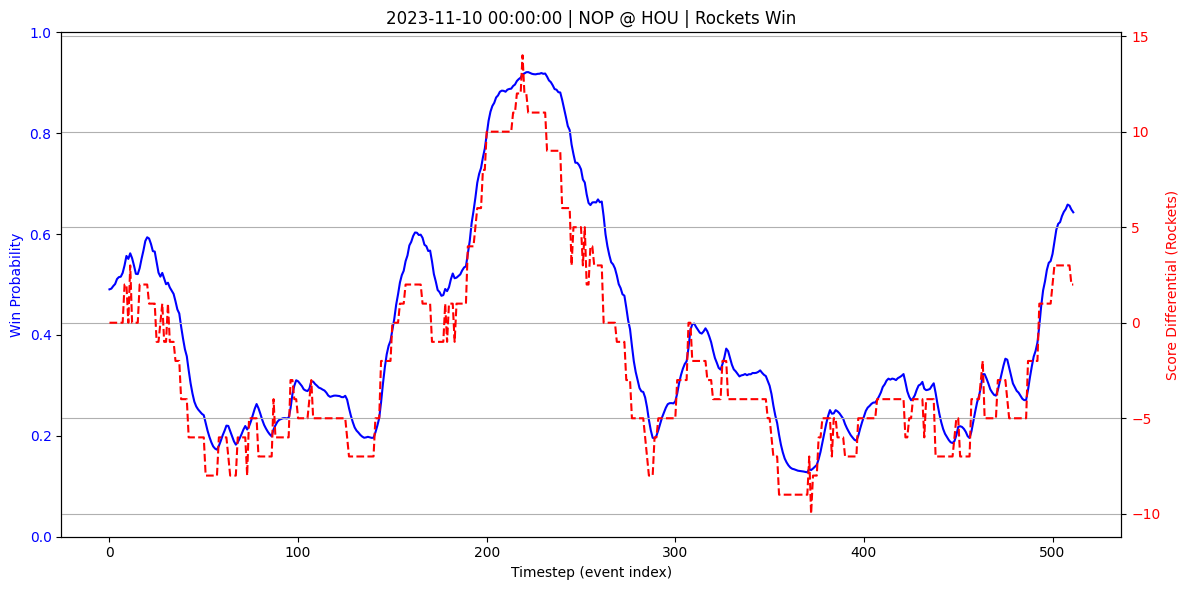

In [158]:
plot_win_prob_over_time(1)

# Discussion / Conclusions:

In this project, we built a recurrent neural network (RNN) model to predict the Houston Rockets’ win probability in real-time using play-by-play NBA game data. The model was trained on sequences of in-game events encoded with features such as time remaining, score differential, possession status, and categorized action types. Each game was modeled as a sequence of up to 512 events.

**Model Performance:**
The model achieved a per-timestep test accuracy of 64.88%, which is a strong baseline for sequence-based win probability prediction, especially given the relatively small dataset of ~80 games. The decreasing training loss across epochs also indicated successful learning.

**Feature Importance:**
Three numeric features (time remaining, score differential, possession) and one categorical feature (action type) contributed to each timestep prediction. The use of embedding layers for action types allowed the model to learn relationships between different play types beyond one-hot encoding.

**Dynamic Prediction Behavior:**
Visual inspection of predicted win probability curves demonstrated that the model adjusted to significant shifts in momentum, such as big scoring runs or critical possessions. Overlaying the score differential helped validate that prediction changes aligned with meaningful in-game events.

## Challenges and Limitations

Data Limitations:
The dataset was limited to the 2023–2024 season and only included Rockets games, which restricted generalizability and training volume. With more seasons and teams, the model could generalize better and potentially perform more accurately.

Labeling Granularity:
The model was trained with a binary game-level outcome (win/loss) applied to all 512 timesteps, which assumes the final result as ground truth throughout the sequence. This introduces noise early in the game when outcomes are highly uncertain. A potential improvement would be to use dynamic labeling (e.g., real-time win probabilities from betting markets or expert sources).

Evaluation Metric:
We evaluated accuracy per timestep, but additional metrics like AUC, cross-entropy loss, or confidence calibration curves could offer deeper insights into model performance.

## Future Improvements

1. Expand Dataset to include multiple seasons and teams for better generalization.

2. Incorporate Advanced Features such as player-level events, foul counts, and lineups.

3. Explore Alternative Architectures like GRUs or Transformers for capturing longer-range dependencies and improving predictive sharpness.

4. Add Real-Time Labels from probabilistic sources to train the model to reflect actual in-game uncertainty.

## Final Thoughts

This project demonstrates the potential of deep learning models—especially RNNs—for real-time sports analytics. Even with limited data, our model was able to capture meaningful dynamics in NBA games and offer an interpretable win probability curve. With continued refinement and data expansion, such models could be used by teams, broadcasters, or analysts to provide live insights during games.